# Classic (numeric) preprocessing

Este notebook es una primera aproximación donde se preprocesará el dataset codificando numéricamente cada par de aminoacidos para en el siguiente notebook hacer el entrenamiento del modelo.

In [5]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

In [6]:
import pandas as pd

df_string_balanced = pd.read_parquet("../datasets/df_string_balanced.parquet")

In [7]:
df_string_balanced.shape

(1828447, 5)

In [5]:
df_string_balanced.head()

,protein1,protein2,label,sequence1,sequence2
0,9606.ENSP00000000233,9606.ENSP00000257770,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MCPRAARAPATLLLALGAVLWPAAGAWELTILHTNDVHSRLEQTSE...
1,9606.ENSP00000000233,9606.ENSP00000226004,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MSGSFELSVQDLNDLLSDGSGCYSLPSQPCNEVTPRIYVGNASVAQ...
2,9606.ENSP00000000233,9606.ENSP00000262455,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MHPAVFLSLPDLRCSLLLLVTWVFTPVTTEITSLDTENIDEILNNA...
3,9606.ENSP00000000233,9606.ENSP00000263265,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MEGSRPRSSLSLASSASTISSLSSLSPKKPTRAVNKIHAFGKRGNA...
4,9606.ENSP00000000233,9606.ENSP00000365686,1,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,MGMSKSHSFFGYPLSIFFIVVNEFCERFSYYGMRAILILYFTNFIS...


## Sequence encoding

Antes de codificar y preparar las secuencias proteicas como entrada al modelo, tenemos que determinar una longitud máxima (`max_length`) para todas ellas. Los modelos de deep learning, especialmente aquellos que trabajan con batches, requieren entradas de tamaño fijo.

Para definir un `max_length` adecuado, analizaremos la distribución de longitudes de todas las secuencias de proteínas involucradas en los pares del dataset. Esto nos permitirá encontrar un equilibrio entre:

- Maximizar la cobertura (evitar truncar demasiadas secuencias)
- Minimizar el uso de memoria y el tiempo de entrenamiento

count    3.656894e+06
mean     6.109886e+02
std      6.572367e+02
min      2.500000e+01
25%      2.760000e+02
50%      4.570000e+02
75%      7.390000e+02
max      3.599100e+04
dtype: float64
Cuantiles:
0.50     457.0
0.75     739.0
0.90    1174.0
0.95    1621.0
0.99    2828.0
dtype: float64


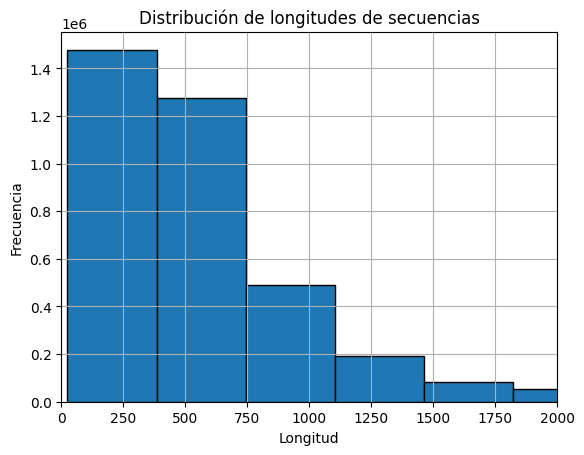

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df_string_balanced["len_seq1"] = df_string_balanced["sequence1"].str.len()
df_string_balanced["len_seq2"] = df_string_balanced["sequence2"].str.len()

lengths = pd.concat([df_string_balanced["len_seq1"], df_string_balanced["len_seq2"]])

print(lengths.describe())
print("Cuantiles:")
print(lengths.quantile([0.5, 0.75, 0.90, 0.95, 0.99]))

plt.hist(lengths, bins=100, edgecolor="black")
plt.title("Distribución de longitudes de secuencias")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.xlim(0, 2000)
plt.grid(True)
plt.show()

El histograma muestra que la gran mayoría de las secuencias tienen una longitud inferior a 1000 aminoácidos. En concreto, los percentiles calculados reflejan que:

- El 90 % de las secuencias tienen ≤ 1174 aminoácidos
- El 95 % tienen ≤ 1621
- El 99 % tienen ≤ 2828

Basándonos en esta distribución, se ha decidido establecer un `max_length` de **1024**. Este valor permite cubrir hasta casi el 90 % de las secuencias sin truncamiento, al tiempo que mantiene un consumo de memoria razonable compatible con la GPU disponible. Las secuencias más largas serán truncadas para ajustarse a esta longitud, mientras que las más cortas serán completadas mediante padding.

In [7]:
df_string_balanced.drop(columns=["len_seq1", "len_seq1"], inplace=True)

In [8]:
from encoders.numeric_protein_encoder import NumericProteinEncoder
from proteins_preprocessor import ProteinsPreprocessor

encoder = NumericProteinEncoder()
preprocessor = ProteinsPreprocessor(encoder, max_length=1024, chunk_size=100000, output_dir="../processed_data/numeric_chunks")
preprocessor.process_dataframe(df_string_balanced)

Processing chunk 1/19...
Processing chunk 2/19...
Processing chunk 3/19...
Processing chunk 4/19...
Processing chunk 5/19...
Processing chunk 6/19...
Processing chunk 7/19...
Processing chunk 8/19...
Processing chunk 9/19...
Processing chunk 10/19...
Processing chunk 11/19...
Processing chunk 12/19...
Processing chunk 13/19...
Processing chunk 14/19...
Processing chunk 15/19...
Processing chunk 16/19...
Processing chunk 17/19...
Processing chunk 18/19...
Processing chunk 19/19...


In [3]:
from utils import load_numpy_dataset

X1, X2, y = load_numpy_dataset("../processed_data/numeric_chunks")
print(f"X1 shape: {X1.shape}")
print(f"X2 shape: {X2.shape}")
print(f"y shape: {y.shape}")

X1 shape: (1828447, 1024)
X2 shape: (1828447, 1024)
y shape: (1828447,)


In [4]:
import random

def display_random_examples(X1, X2, y, n=5):
    for _ in range(n):
        idx = random.randint(0, len(y) - 1)
        print(f"Example {idx}:")
        print(f"Input 1: {X1[idx]}")
        print(f"Input 2: {X2[idx]}")
        print(f"Label: {y[idx]}")
        print("-" * 40)
display_random_examples(X1, X2, y, n=5)

Example 1509292:
Input 1: [10  0  6 ...  0  0  0]
Input 2: [10  6  2 ...  0  0  0]
Label: 1
----------------------------------------
Example 195776:
Input 1: [10  0  2 ...  5  6  9]
Input 2: [10 16 15 ... 12  9  0]
Label: 0
----------------------------------------
Example 446543:
Input 1: [10 15  1 ...  0  0  0]
Input 2: [10 12  3 ...  0  0  0]
Label: 0
----------------------------------------
Example 233703:
Input 1: [10  3  3 ...  0  0  0]
Input 2: [10 17 13 ...  0  0  0]
Label: 0
----------------------------------------
Example 1546234:
Input 1: [10  5  0 ...  0  0  0]
Input 2: [10  0  3 ...  0  0  0]
Label: 1
----------------------------------------


### Conclusión del preprocesamiento

En este notebook se ha llevado a cabo el preprocesamiento completo del dataset de interacciones proteína-proteína (PPI) con evidencia experimental directa, extraído de la base de datos STRING.

El proceso incluyó la asociación de secuencias de aminoácidos mediante identificadores Ensembl, la codificación numérica de las secuencias con una longitud máxima de 1024 residuos, y el etiquetado binario de las interacciones (positivas y negativas). Para ello se implementaron clases reutilizables siguiendo principios de diseño limpio y modular, como `SequencePreprocessor` y `SequenceEncoder`.

El resultado es un directorio con nuestros datos correctamente preprocesados por chunks en formato `.npy`, listos para ser utilizados en la fase de entrenamiento del modelo de deep learning. Este enfoque desacopla el procesamiento de datos del entrenamiento, facilitando futuras pruebas con distintos modelos y codificadores sin necesidad de repetir esta etapa.
